In [1]:
import xarray as xr
import xarray.ufuncs as xrf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from scipy import stats

In [2]:
#SET STATION HERE
station = 'CMA'
root_path = '/home/gemeinsam_tmp/UA_students/data/'
alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]


In [3]:
cmap = 'coolwarm'
vmin= -5
vmax = 5
gwmin = -1
gwmax = 1

# Meteor radars

* Dav        Davis; GW:200501-201912
* Col         Collm (Leipzig); GW:200408-201903
* Rio         RioGrande (SAAMER- Argentina); GW:200802-201912
* Sod        Sodankyla; GW:200810-201912
* Kir          Kiruna (Sweden ? Esrange); GW:199908-201912
* CMA      CMOR (Canada ? CMA (CMOR All) triple frequency data); GW:200201-201812
* SES        Sodankyla ? Esrange merged (assigned either to Esrange or Sodankyla or a virtual center in between); GW:199908-201912


Dav_start = '2005-01-'
Dav_end = '2019-12-'
Col_start = '2004-08-01'
Col_end='2019-03-06'
Rio_start = '2008-02-01'
Rio_end = '2019-12-31'
Sod_start = '2008-10-'
Sod_end = '2019-12-'
Kir_start = '1999-08-'
Kir_end = '2019-12-'
Cma_start = '2002-01-01'
Cma_end = '2018-12-31'
Ses_start = '1999-08-'
Ses_end = '2019-12-'


# FUNCTIONS

### lineare regression

In [4]:
def new_linregress(y):
   
    x = np.arange(y.shape[0])
    mask = ~np.isnan(y)
    #print('y: '+str(y))
    #print('x: '+str(x))
    
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    return np.array([slope, intercept, r_value, p_value, std_err])
    

def new_linregress_masked(y):
   
    x = np.arange(y.shape[0])
    mask = ~np.isnan(y)
    #print('y: '+str(y))
    #print('x: '+str(x))
    
    try:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
    except:
        slope, intercept, r_value, p_value, std_err = np.nan, np.nan, np.nan, np.nan, np.nan
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    return np.array([slope, intercept, r_value, p_value, std_err])
    

def time_reg(var):
        #print('var:'+str(var.values))
        statistics = xr.apply_ufunc(new_linregress, var, 
                       input_core_dims=[['time']],
                       output_core_dims=[["parameter"]],
                       vectorize=True,
                       dask="allowed", 
                       output_dtypes=['float64'],
                       output_sizes={"parameter": 5},
                      )
        return statistics

def time_reg_masked(var):
        #print('var:'+str(var.values))
        statistics = xr.apply_ufunc(new_linregress_masked, var, 
                       input_core_dims=[['time']],
                       output_core_dims=[["parameter"]],
                       vectorize=True,
                       dask="allowed",
                       output_dtypes=['float64'],
                       output_sizes={"parameter": 5},
                      )
        return statistics

def is_mon(month,sta,end):
    return (month >= sta) & (month <= end)

def grav_waves(wind_component,loc): # Beides muss schon als String reingegeben werden! 
    ds = read_group('wind',loc)
    gw = read_var(ds,wind_component) - read_var(ds,wind_component+'_fil')
    return gw

def kin_energy_grav_waves(loc):
    kin_energy = 0.5*((grav_waves('u',loc))**2 + (grav_waves('v',loc))**2)
    return kin_energy



### Variable einlesen

In [5]:
def read_group(gruppe,loc):
    station = loc#ersten Buchstaben bitte bitte groß schreiben
    
    if loc=='Rio':
        timestart = '2008-02-01'
        timeend = '2019-12-31'
    elif loc == 'Col':
        timestart =  '2004-08-01'
        timeend =  '2019-03-06'
    elif loc=='CMA':
        timestart = '2002-01-01'
        timeend = '2018-12-31'    

    elif loc=='Kir':
        timestart = '1999-08-01'
        timeend = '2018-12-31'
        
    elif loc=='Dav':
        timestart = '2005-01-01'
        timeend = '2019-12-31'   
        
        
    infiles = f'{root_path}{station}/Meteor_radar_{station}_GW_*.h5'
    ds = xr.open_mfdataset(infiles, concat_dim = 'phony_dim_6', group = gruppe, combine='nested',parallel = True)
    ds = ds.rename({'phony_dim_6': 'time', 'phony_dim_7': 'alt'})
    #ds=ds.chunk({'alt': 12})
    ds['alt'] = alt
    ds['alt'].attrs['units'] = 'km'
    # change time range according to meteor radar station
    ds['time'] = pd.date_range(start = timestart, end = timeend, periods = ds.time.shape[0]) 
    return ds
    
    

In [6]:
def read_var(gruppe, var):
        varout = gruppe[var]
        return varout

### Horizontal Wind

In [7]:
def hwind(u,v):
    return np.sqrt(u**2+v**2)
    

### time mean

In [8]:
def time_mean(step,var):
    return var.resample(time='1'+step).mean('time') #Immer nur D oder M oder H oder Y eintragen! Mit Anführungszeichen!
    
    

### Amomalies

In [9]:
def anomalie(step,var):
    string = "time."+step   
    climatology = var.groupby(string).mean("time")
    anomalies = var.groupby(string) - climatology
    
    return anomalies




## Radar Measurements

In [10]:
ds_radar= read_group('wind',station)
u_radar = read_var(ds_radar,'u')  
v_radar = read_var(ds_radar,'v')

u_radar_ano = anomalie('day',u_radar)
v_radar_ano = anomalie('day',u_radar)

u_radar_monano = anomalie('month',u_radar)
v_radar_monano = anomalie('month',v_radar)

u_radar_monthly_ano = time_mean('M',u_radar_monano)
v_radar_monthly_ano = time_mean('M',v_radar_monano)

u_radar_monthly = time_mean('M',u_radar)
v_radar_monthly = time_mean('M',v_radar)

u_radar_yearano = anomalie('month',u_radar)
v_radar_yearano = anomalie('month',v_radar)

u_radar_yearly_ano = time_mean('Y',u_radar_yearano)
v_radar_yearly_ano = time_mean('Y',v_radar_yearano)

In [11]:
u_gw_radar = grav_waves('u',station)
v_gw_radar = grav_waves('v',station)

u_gw_radar_monthly = time_mean('M',u_gw_radar)
v_gw_radar_monthly = time_mean('M',v_gw_radar)

u_gw_radar_monano = anomalie('month',u_gw_radar)
v_gw_radar_monano = anomalie('month',v_gw_radar)

u_gw_radar_monthly_ano = time_mean('M',u_gw_radar_monano)
v_gw_radar_monthly_ano = time_mean('M',v_gw_radar_monano)

ekin_radar = kin_energy_grav_waves(station)
ekin_radar_monthly = time_mean('M',ekin_radar)
ekin_radar_monano = anomalie('month', ekin_radar)
ekin_radar_monthly_ano = time_mean('M', ekin_radar_monano) 

### Montsmittel über den gesamten Zeitraum

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


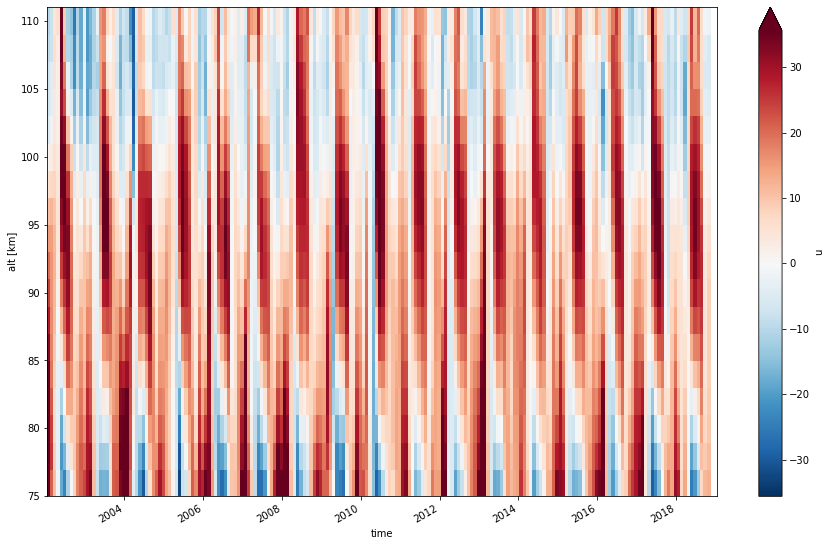

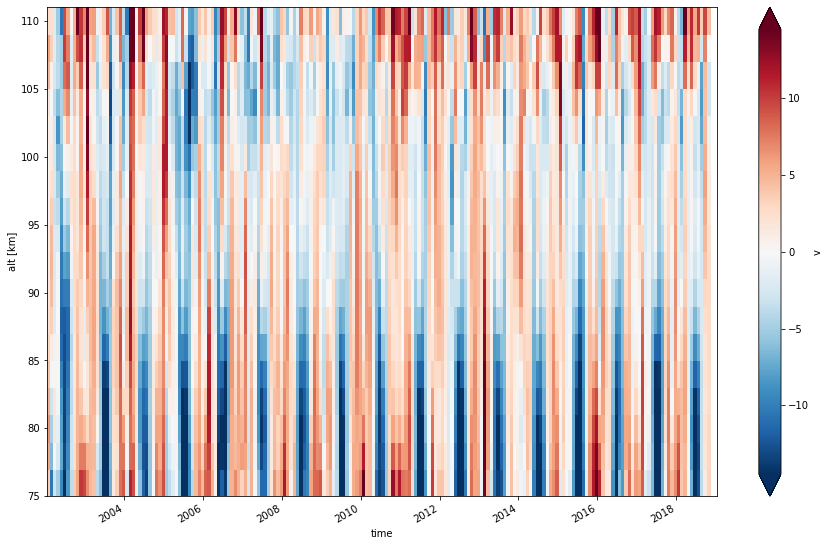

In [12]:
#u_radar_monthly_ano.plot(x = 'time')
u_radar_monthly_slice=u_radar_monthly.sel(alt = slice(75,110))
ax1 = u_radar_monthly_slice.plot(x='time',robust=True,figsize = [15,9])
v_radar_monthly_slice=v_radar_monthly.sel(alt = slice(75,110))
ax2 = v_radar_monthly_slice.plot(x='time',robust=True,figsize = [15,9])

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


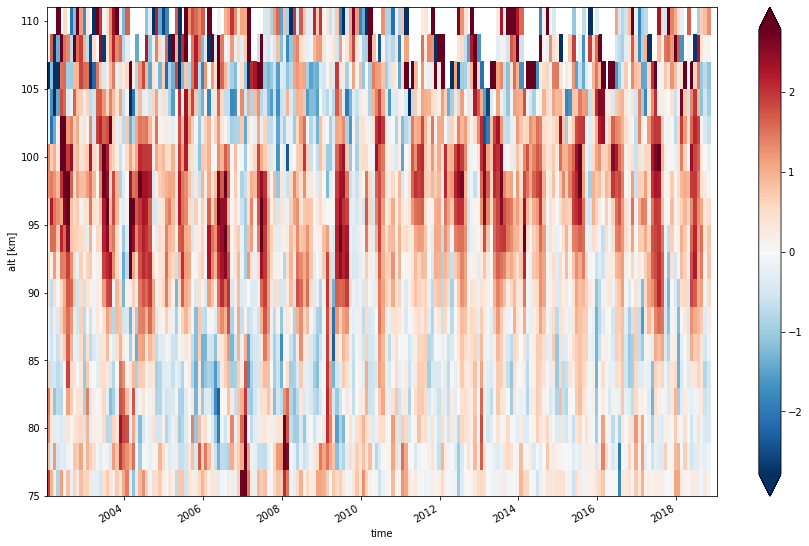

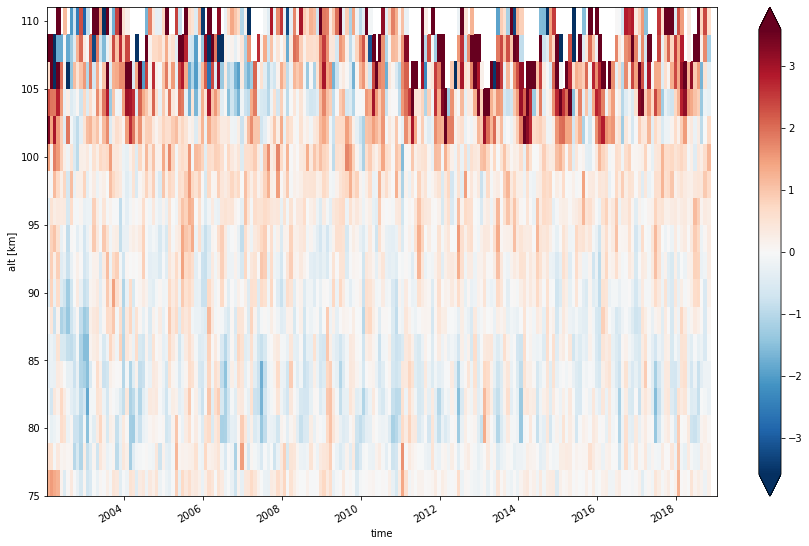

In [13]:
## GRAVITY WAVES
u_gw_radar_monthly_slice=u_gw_radar_monthly.sel(alt = slice(75,110))
ax1 = u_gw_radar_monthly_slice.plot(x='time',robust=True,figsize = [15,9])
v_gw_radar_monthly_slice=v_gw_radar_monthly.sel(alt = slice(75,110))
ax2 = v_gw_radar_monthly_slice.plot(x='time',robust=True,figsize = [15,9])


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


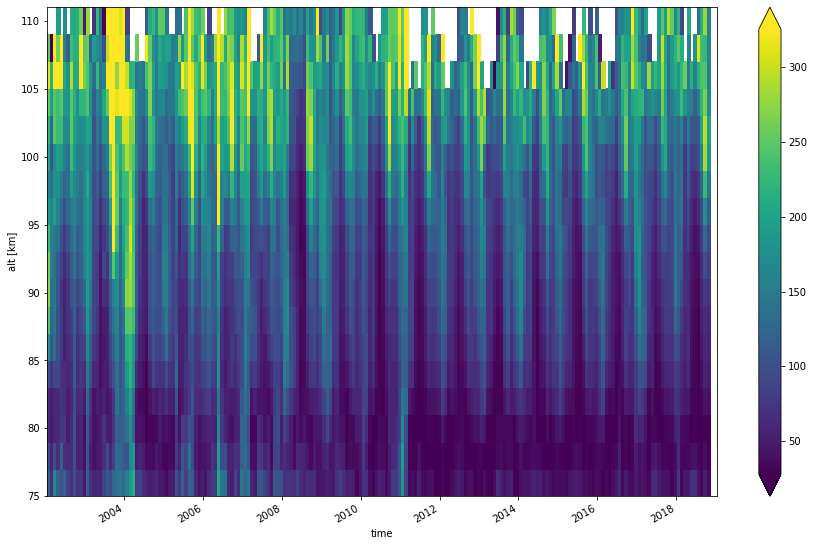

In [14]:
## GRAVITY WAVE KINETIC ENERGY
ekin_monthly_slice=ekin_radar_monthly.sel(alt = slice(75,110))
ax1 = ekin_monthly_slice.plot(x='time',robust=True,figsize = [15,9])


### simple climatologies


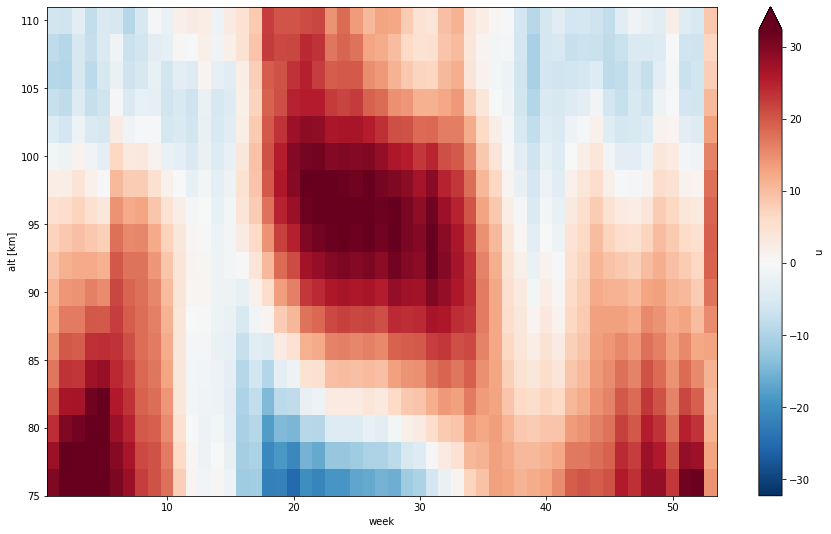

In [15]:
u_radar_clima = u_radar.groupby('time.week').mean("time")
u_radar_clima_slice=u_radar_clima.sel(alt = slice(75,110))
ax1 = u_radar_clima_slice.plot(x = 'week',robust=True,figsize = [15,9])
plt.savefig('u_clima_'+station+'.png')

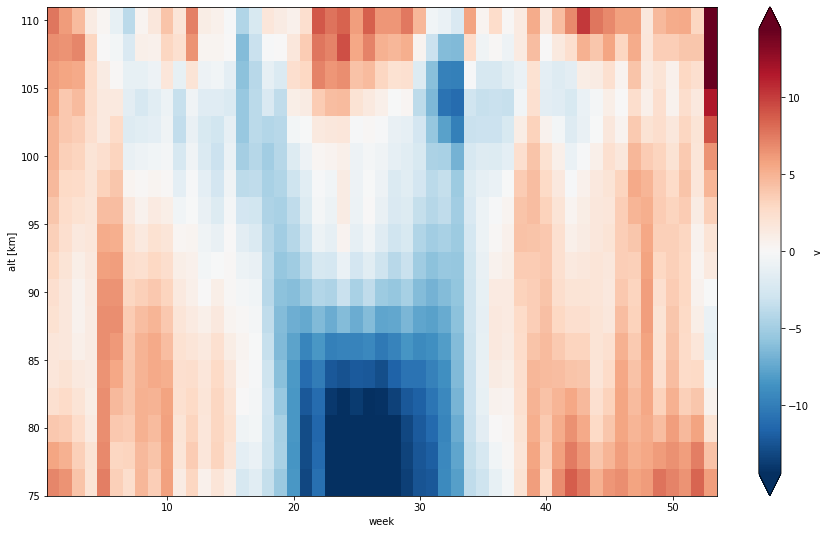

In [16]:
v_radar_clima = v_radar.groupby('time.week').mean("time")
v_radar_clima_slice=v_radar_clima.sel(alt = slice(75,110))
ax1 = v_radar_clima_slice.plot(x = 'week',robust=True,figsize = [15,9])
plt.savefig('v_clima_'+station+'.png')

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


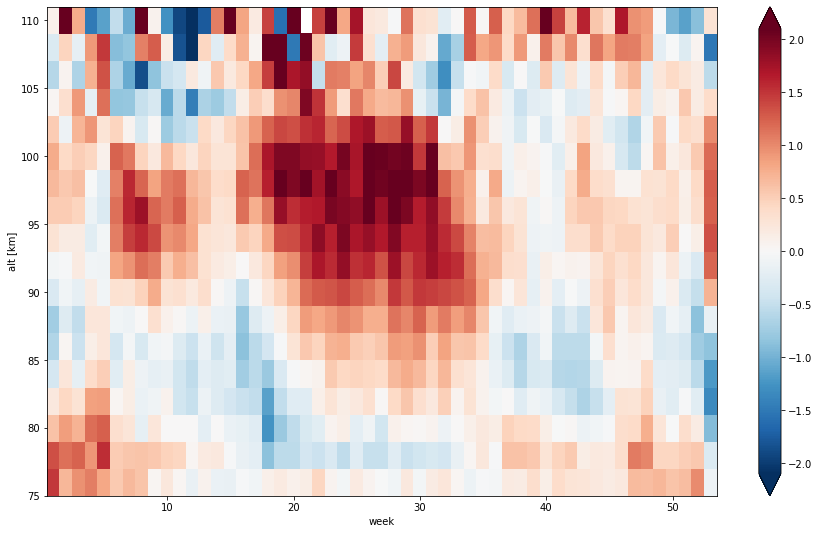

In [17]:
u_gw_radar_clima = u_gw_radar.groupby('time.week').mean("time")
u_gw_radar_clima_slice=u_gw_radar_clima.sel(alt = slice(75,110))
ax1 = u_gw_radar_clima_slice.plot(x = 'week',robust=True,figsize = [15,9])
plt.savefig('u_gw_clima_'+station+'.png')

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


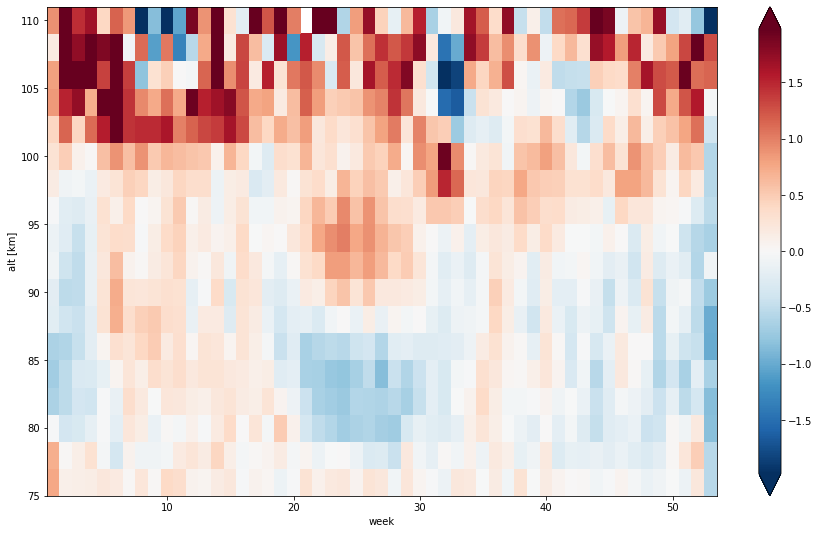

In [18]:
v_gw_radar_clima = v_gw_radar.groupby('time.week').mean("time")
v_gw_radar_clima_slice=v_gw_radar_clima.sel(alt = slice(75,110))
ax1 = v_gw_radar_clima_slice.plot(x = 'week',robust=True,figsize = [15,9])
plt.savefig('v_gw_clima_'+station+'.png')

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


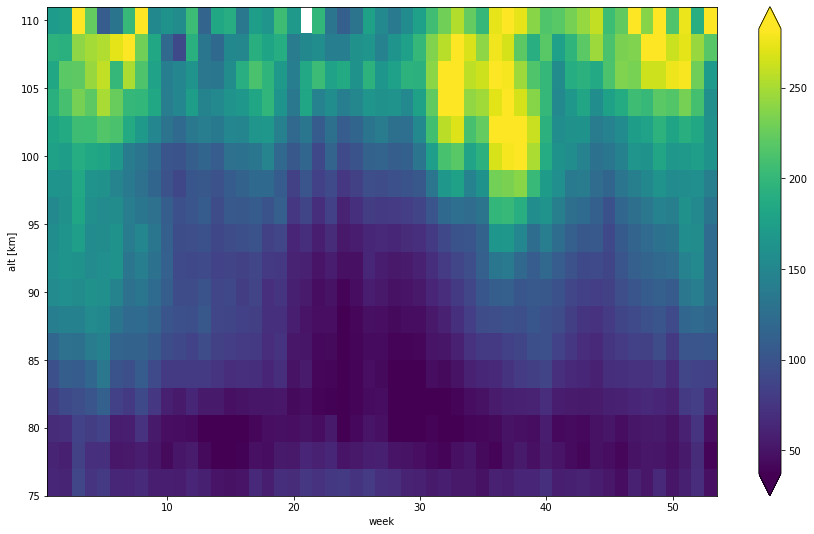

In [19]:
ekin_radar_clima = ekin_radar.groupby('time.week').mean("time")
ekin_radar_clima_slice=ekin_radar_clima.sel(alt = slice(75,110))
ax1 = ekin_radar_clima_slice.plot(x = 'week',robust=True,figsize = [15,9])
plt.savefig('ekin_clima_'+station+'.png')

Normale Zirkulation:
u: im winter nach osten im sommer nach westen. vorzeichen dreht sich zwischen 90 und 100 km um
v: im in richtung Winter

### look at specific months

In [20]:
#Analyse Months seperatly
s = 3
e = 3
u_radar_examon = u_radar_monthly_ano.sel(time=is_mon(u_radar_monthly_ano['time.month'],s,e))
v_radar_examon = v_radar_monthly_ano.sel(time=is_mon(v_radar_monthly_ano['time.month'],s,e))


xu = np.arange(u_radar_examon.time.shape[0])
u_statistics = time_reg(u_radar_examon)
u_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']

xv=np.arange(np.squeeze(v_radar_examon.time.shape))
v_statistics = time_reg(v_radar_examon)
v_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'u' (alt: 1)>
array([-0.11277732])
Coordinates:
  * alt        (alt) int64 90
    parameter  <U9 'slope'


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'v' (alt: 1)>
array([-0.15425897])
Coordinates:
  * alt        (alt) int64 110
    parameter  <U9 'slope'


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0, 0.5, 'Monthly averaged wind speed')

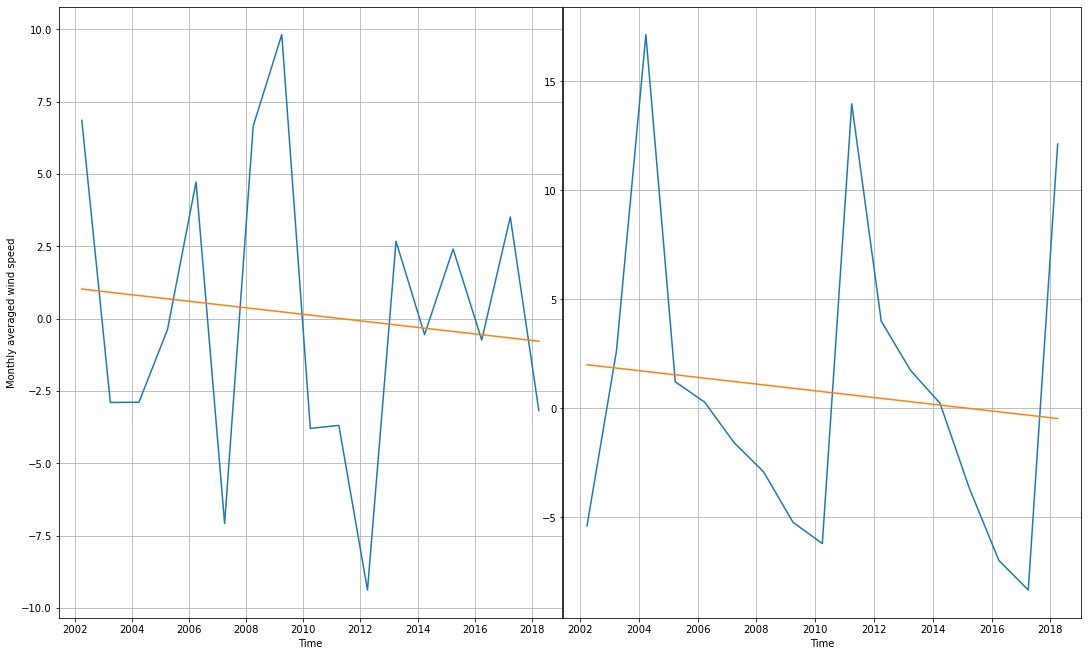

In [21]:
#plot actual DATA

fig = plt.figure(constrained_layout=True,figsize = [15,9])
z = 90
m = (u_statistics.sel(parameter='slope',alt=[z]))
print(m)
n = (u_statistics.sel(parameter='intercept',alt=[z]))
reg = [m*i+n for i in xu]

windsel=u_radar_examon.sel(alt = [z], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_radar_examon.time,windsel)
ax1.plot(u_radar_examon.time,reg)

ax1.grid()

z = 110
m = (v_statistics.sel(parameter='slope',alt=[z]))
print(m)
n = (v_statistics.sel(parameter='intercept',alt=[z]))
reg = [m*i+n for i in xv]
windsel=v_radar_examon.sel(alt = [z], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(v_radar_examon.time,windsel)
ax2.plot(u_radar_examon.time,reg)
ax2.grid()


ax1.set_xlabel('Time')
ax2.set_xlabel('Time')
ax1.set_ylabel('Monthly averaged wind speed')


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

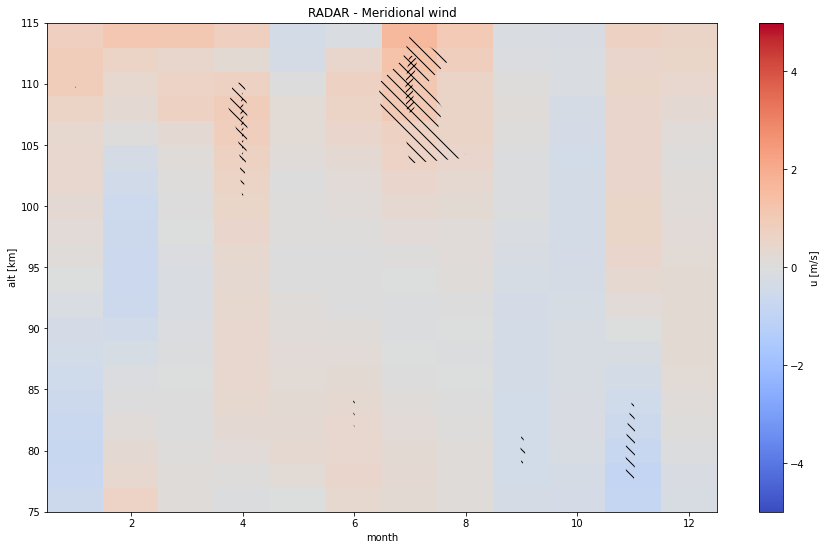

In [22]:
u_statistics = time_reg_masked(u_radar_monthly_ano.groupby('time.month'))
u_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


#u
temp = u_statistics.sel(parameter='slope', alt = slice(75,115)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='month',figsize = [15,9], vmin=vmin,vmax=vmax,cmap = cmap )
ax = p.axes
plot_kwargs2 = dict(x ='month',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = u_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('RADAR - Meridional wind')
ax.figure.savefig('results/cont_u_radar_'+station+'_mon.png')

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

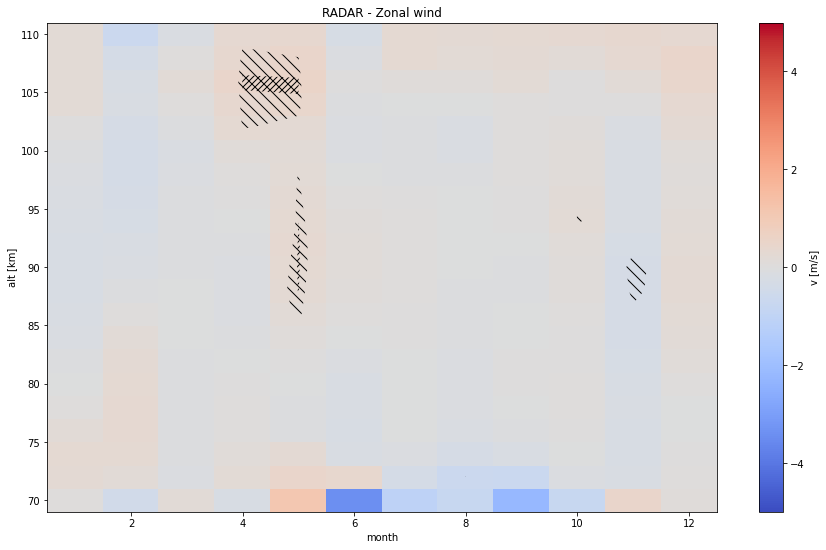

In [23]:
v_statistics = time_reg_masked(v_radar_monthly_ano.groupby('time.month'))
v_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


#u
temp = v_statistics.sel(parameter='slope', alt = slice(70,110)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='month',figsize = [15,9],vmin=vmin,vmax=vmax,cmap = cmap)
ax = p.axes
plot_kwargs2 = dict(x ='month',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = v_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('RADAR - Zonal wind')
ax.figure.savefig('results/cont_v_radar_'+station+'.png')

## Gravity Waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

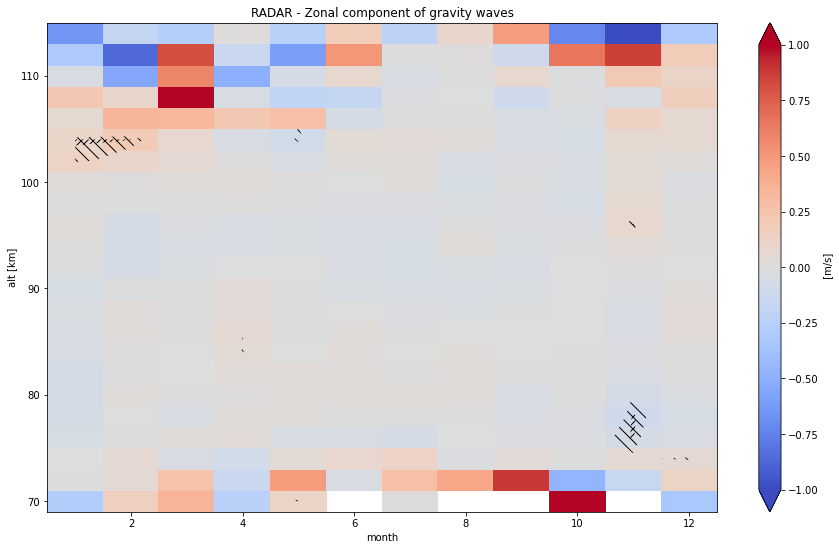

In [24]:
u_gw_statistics = time_reg_masked(u_gw_radar_monthly_ano.groupby('time.month'))
u_gw_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


#u
temp = u_gw_statistics.sel(parameter='slope', alt = slice(70,115)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='month',figsize = [15,9], vmin = gwmin, vmax = gwmax, cmap=cmap )
ax = p.axes
plot_kwargs2 = dict(x ='month',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = u_gw_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('RADAR - Zonal component of gravity waves')
ax.figure.savefig('results/cont_u_gw_radar_'+station+'_mon.png')

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

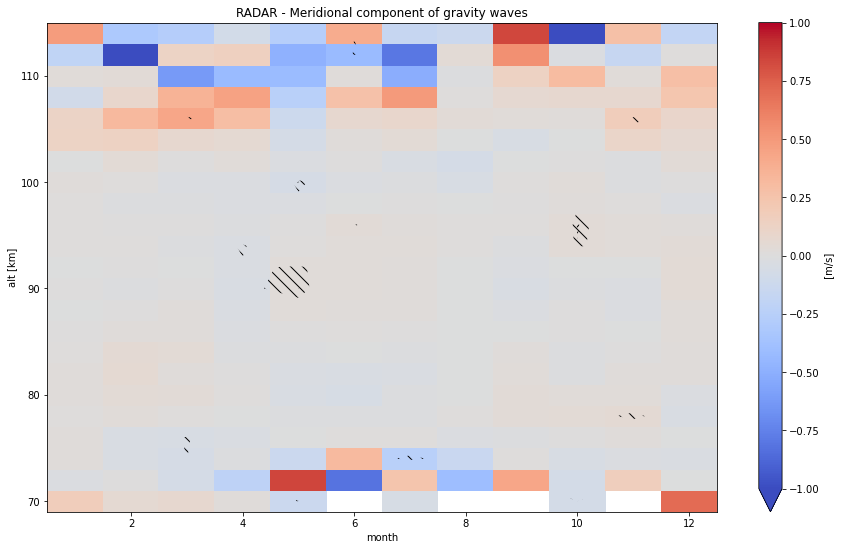

In [25]:
v_gw_statistics = time_reg_masked(v_gw_radar_monthly_ano.groupby('time.month'))
v_gw_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


#u
#temp = v_gw_statistics.sel(parameter='slope', alt = slice(70,115)) 
temp = v_gw_statistics.sel(parameter='slope', alt = slice(70,115)) 

temp.attrs['units'] = 'm/s'
p = temp.plot(x='month',figsize = [15,9],vmin = gwmin, vmax = gwmax, cmap=cmap)
ax = p.axes
plot_kwargs2 = dict(x ='month',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = v_gw_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('RADAR - Meridional component of gravity waves')
ax.figure.savefig('results/cont_v_gw_radar_'+station+'_mon.png')

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

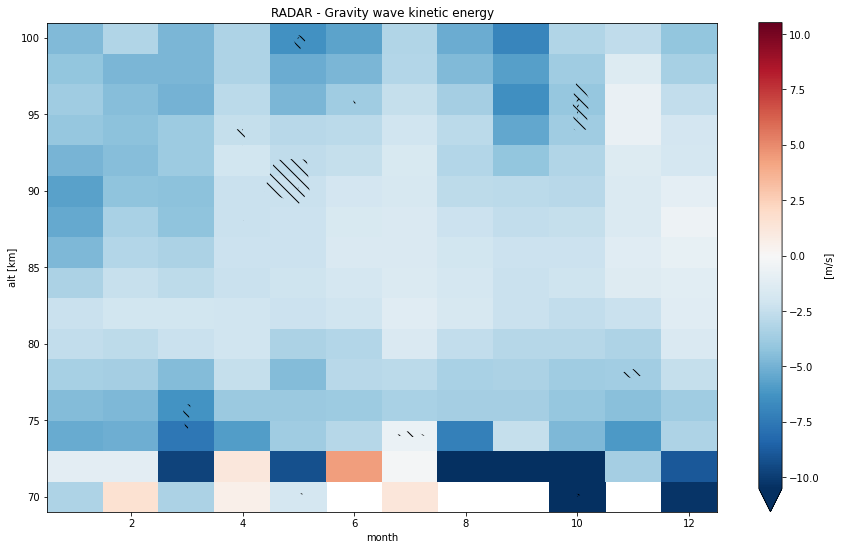

In [26]:
ekin_statistics = time_reg_masked(ekin_radar_monthly_ano.groupby('time.month'))
ekin_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


#u
#temp = v_gw_statistics.sel(parameter='slope', alt = slice(70,115)) 
temp = ekin_statistics.sel(parameter='slope', alt = slice(70,100)) 

temp.attrs['units'] = 'm/s'
p = temp.plot(x='month',figsize = [15,9], robust = True)
ax = p.axes
plot_kwargs2 = dict(x ='month',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = v_gw_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('RADAR - Gravity wave kinetic energy')
ax.figure.savefig('results/ekin_radar_'+station+'_mon.png')

# GAIA

## Functions for GAIA

In [27]:
root_path = '/home/gemeinsam_tmp/UA_students/data/'
fname = ''

In [28]:
def read_gaia_group(gruppe,loc):
   
    if loc=='Rio':
        timestart = '2008-02-01'
        timeend = '2019-12-31'
        fname = 'GAIA_Rio_20080201_20141231_run20200603.nc'
    
    elif loc == 'Col':
        timestart =  '2004-08-01'
        timeend =  '2017-12-31'
        fname= 'GAIA_Col_20040801_20171231_run20200604.nc'
    
    elif loc=='CMA':
        timestart = '2002-01-01'
        timeend = '2018-12-31'
        fname = 'GAIA_CMA_20020101_20171231_run20200531.nc'
    elif loc=='Kir':
        timestart = '1999-08-01'
        timeend = '2017-12-31'
        fname = 'GAIA_Kir_19990801_20171231_run20200605.nc'    
    elif loc=='Dav':
        timestart = '2005-01-01'
        timeend = '2017-12-31'
        fname = 'GAIA_Dav_20050101_20171231_run20200604.nc'  
    
    infile = f'{root_path}{fname}'
    ds = xr.open_dataset(infile, group=gruppe)
    ds['time'] = pd.date_range(start = timestart, end = timeend, periods=ds.time.shape[0])
    ds = ds.chunk({'alt': 12})
    return ds

def gaia_grav_waves(wind_component, loc):
    ds = read_gaia_group('GAIA',loc)
    #gw = read_var(ds,wind_component) - read_var(ds,wind_component+'_fil')
    if wind_component == 'u':
        #gw = ds.u_fil
        gw = ds.u - ds.u_fil
    elif wind_component == 'v':
        gw = ds.v - ds.v_fil
    return gw

## Gaia Simulations

In [29]:
ds = read_gaia_group('GAIA',station)
#print(ds)
u_gaia = ds.u
v_gaia = ds.v

u_gaia_monano = anomalie('month',u_gaia)
v_gaia_monano = anomalie('month',v_gaia)

u_gaia_monthly_ano = time_mean('M',u_gaia_monano)
v_gaia_monthly_ano = time_mean('M',v_gaia_monano)

u_gaia_monthly = time_mean('M',u_gaia)
v_gaia_monthly = time_mean('M',v_gaia)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 17 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 17 times more chunks
  return self.array[key]


In [30]:

ds

<xarray.Dataset>
Dimensions:    (alt: 93, time: 140256)
Coordinates:
  * alt        (alt) float64 16.0 18.0 20.0 22.0 ... 340.0 360.0 380.0 400.0
  * time       (time) datetime64[ns] 2002-01-01 ... 2018-12-31
Data variables:
    u          (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    v          (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    w          (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    u_err      (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    v_err      (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    w_err      (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    temp       (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    temp_err   (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    u_fil      (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    v_fil      (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    w_fil      (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    u_fil_err  (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    v_fil_err  (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    w_fil_err  (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    u0         (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    v0         (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    w0         (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    u0_err     (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    v0_err     (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    w0_err     (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    T_fil      (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    T_fil_err  (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    T0         (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    T0_err     (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    A24u       (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    A24v       (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    p24u       (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    p24v       (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    A24u_err   (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    A24v_err   (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    p24u_err   (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    p24v_err   (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    A12u       (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    A12v       (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    p12u       (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    p12v       (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    A12u_err   (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    A12v_err   (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    p12u_err   (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    p12v_err   (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    A8u        (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    A8v        (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    p8u        (time, alt) float64 dask.array<chunksize=(140256, 12), meta=np.ndarray>
    p8v        (time, alt) float64

In [31]:
u_gw_gaia = gaia_grav_waves('u',station)
v_gw_gaia = gaia_grav_waves('v',station)

u_gw_gaia_monthly = time_mean('M',u_gw_gaia)
v_gw_gaia_monthly = time_mean('M',v_gw_gaia)

u_gw_gaia_monano = anomalie('month',u_gw_gaia)
v_gw_gaia_monano = anomalie('month',v_gw_gaia)

u_gw_gaia_monthly_ano = time_mean('M',u_gw_gaia_monano)
v_gw_gaia_monthly_ano = time_mean('M',v_gw_gaia_monano)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 17 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 17 times more chunks
  return self.array[key]


### Monatsmittel über den gesamten Zeitraum

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


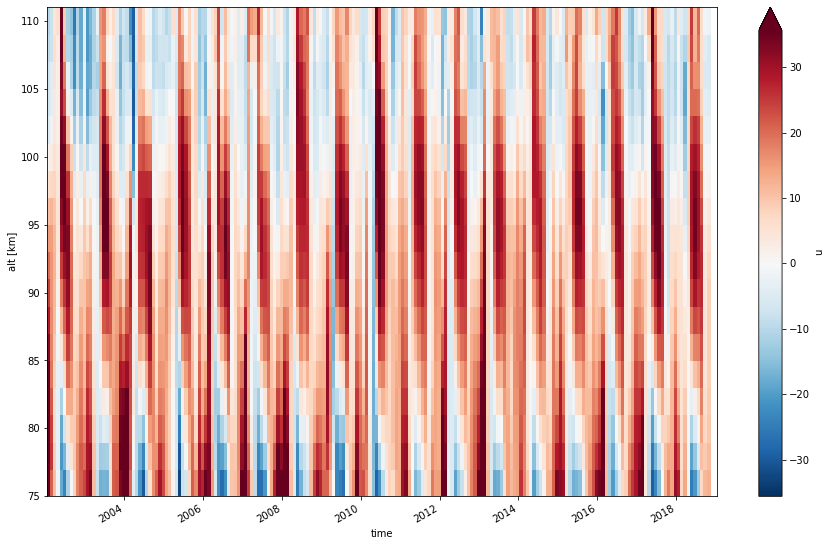

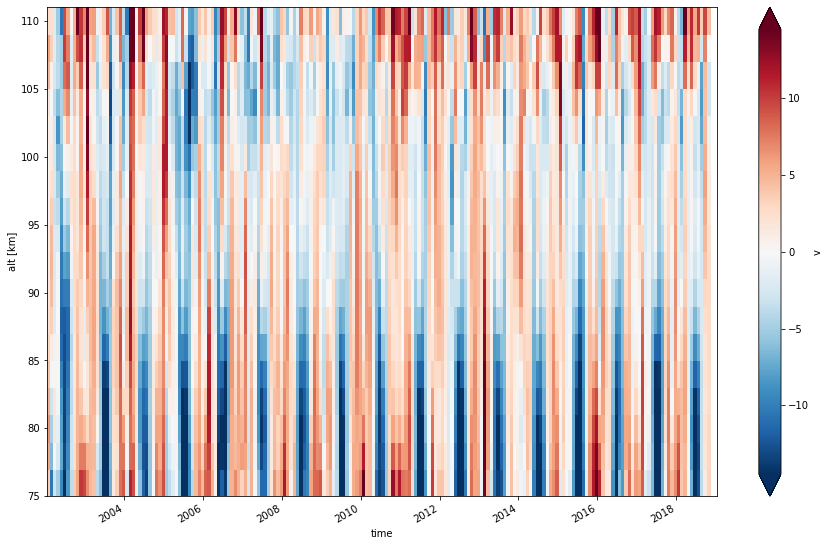

In [32]:
#u_radar_monthly_ano.plot(x = 'time')
u_gaia_monthly_slice=u_radar_monthly.sel(alt = slice(75,110))
ax1 = u_gaia_monthly_slice.plot(x='time',robust=True,figsize = [15,9])
v_gaia_monthly_slice=v_radar_monthly.sel(alt = slice(75,110))
ax2 = v_gaia_monthly_slice.plot(x='time',robust=True,figsize = [15,9])

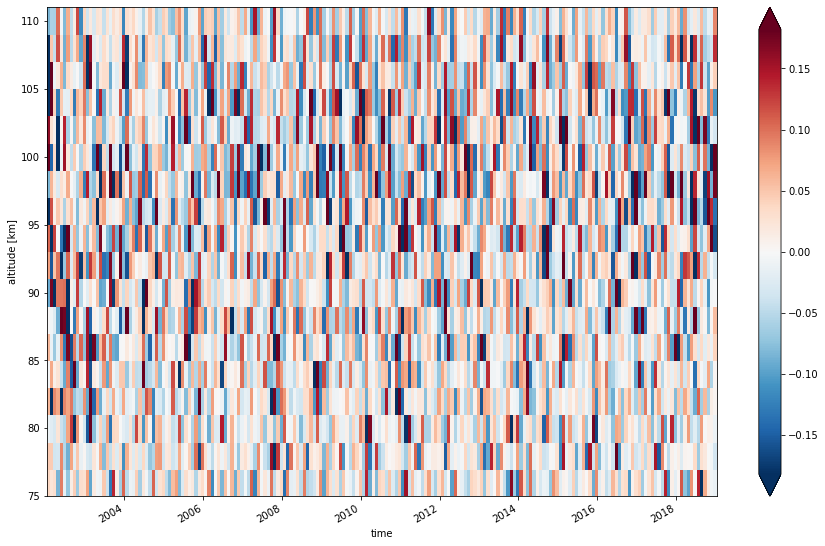

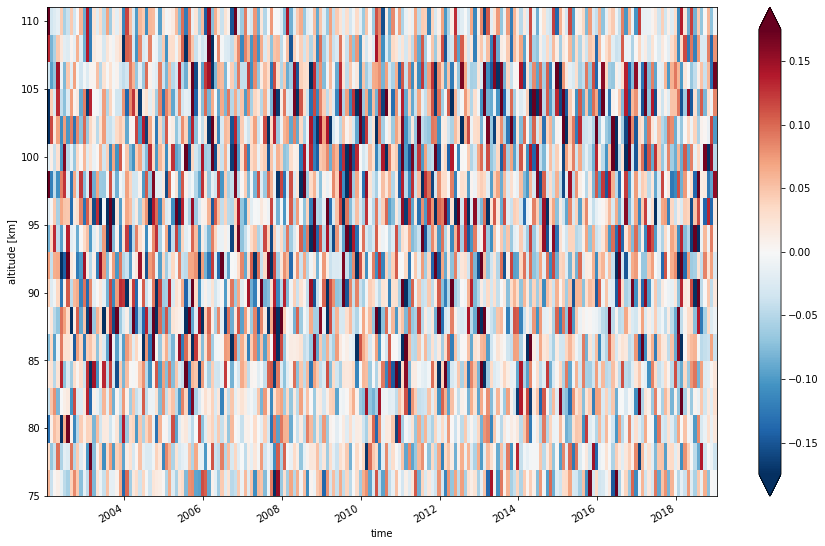

In [33]:
## GRAVITY WAVES
u_gw_gaia_monthly_slice=u_gw_gaia_monthly.sel(alt = slice(75,110))
ax1 = u_gw_gaia_monthly_slice.plot(x='time',robust=True,figsize = [15,9])
v_gw_gaia_monthly_slice=v_gw_gaia_monthly.sel(alt = slice(75,110))
ax2 = v_gw_gaia_monthly_slice.plot(x='time',robust=True,figsize = [15,9])

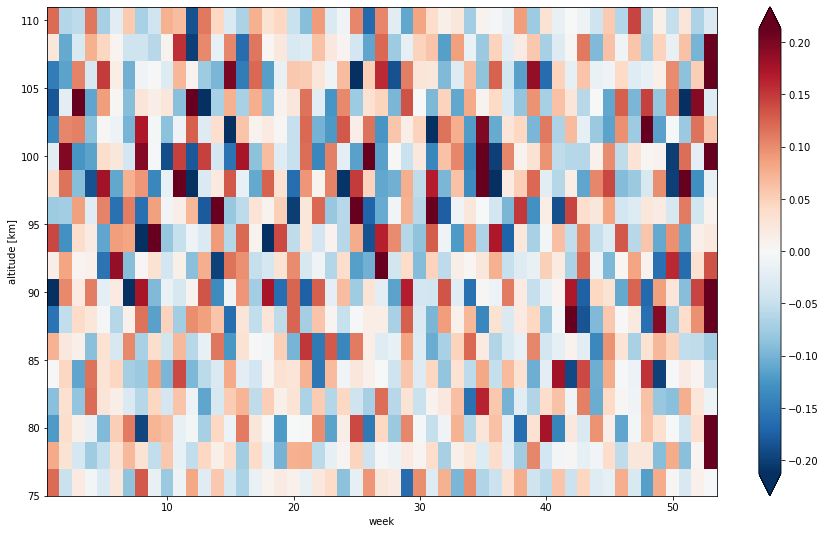

In [43]:
u_gw_gaia_clima = u_gw_gaia.groupby('time.week').mean("time")
u_gw_gaia_clima_slice=u_gw_gaia_clima.sel(alt = slice(75,110))
ax1 = u_gw_gaia_clima_slice.plot(x = 'week',robust=True,figsize = [15,9])
#plt.savefig('u_gw_clima_'+station+'.png')

### Contour plots for Gaia

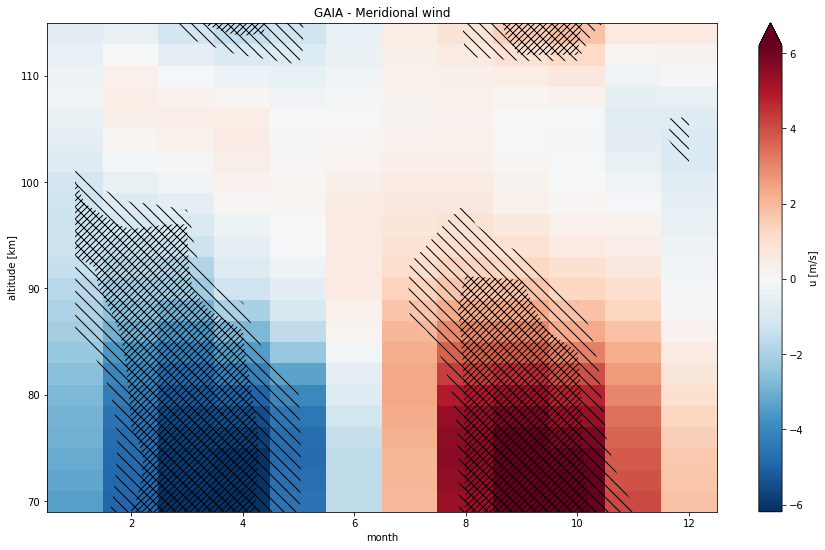

In [34]:
u_statistics = time_reg(u_gaia_monthly_ano.groupby('time.month'))
u_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


#u
temp = u_statistics.sel(parameter='slope', alt = slice(70,115)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='month',figsize = [15,9],robust=True)
ax = p.axes
plot_kwargs2 = dict(x ='month',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = u_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('GAIA - Meridional wind')
ax.figure.savefig('results/cont_u_gaia_'+station+'_mon.png')

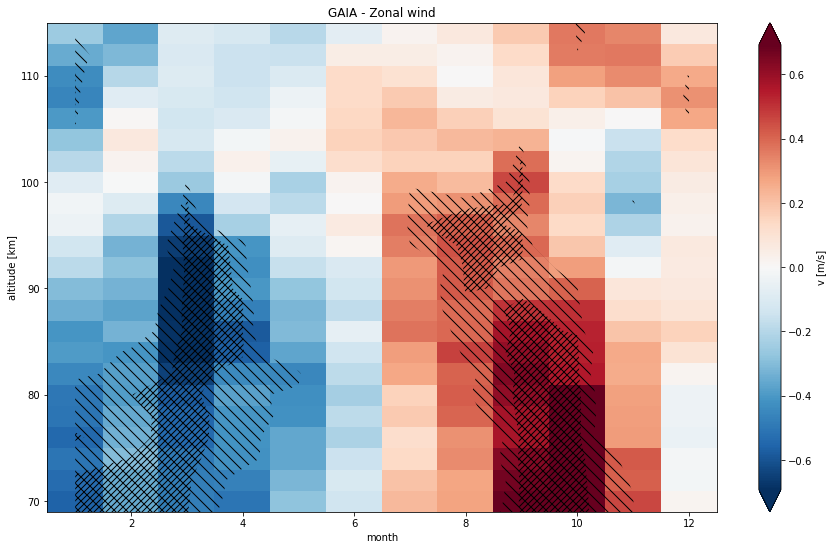

In [35]:
#v
v_statistics = time_reg(v_gaia_monthly_ano.groupby('time.month'))
v_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']

temp = v_statistics.sel(parameter='slope', alt = slice(70,115)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='month',figsize = [15,9],robust=True)
ax = p.axes
plot_kwargs2 = dict(x ='month',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = v_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('GAIA - Zonal wind')
ax.figure.savefig('results/cont_gaia_v_'+station+'.png')

### Analyzing specific months from GAIA

In [36]:
#Analyse Months seperatly
s = 7
e = 7
u_gaia_examon = u_gaia_monthly_ano.sel(time=is_mon(u_gaia_monthly_ano['time.month'],s,e))
v_gaia_examon = v_gaia_monthly_ano.sel(time=is_mon(v_gaia_monthly_ano['time.month'],s,e))

u_statistics_gaia = time_reg(u_gaia_examon)
u_statistics_gaia['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
xu = np.arange(np.squeeze(u_gaia_examon.time.shape))
v_statistics_gaia = time_reg(v_gaia_examon)
v_statistics_gaia['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
xv = np.arange(np.squeeze(v_gaia_examon.time.shape))




Text(0, 0.5, 'Monthly averaged wind speed')

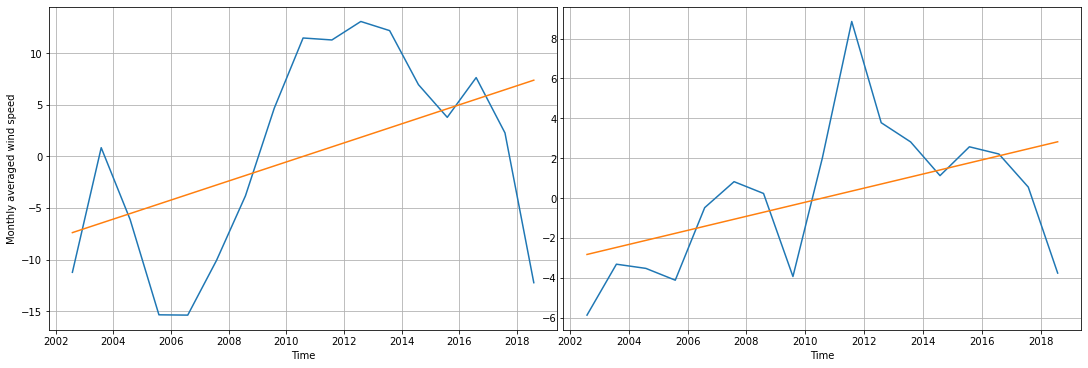

In [37]:
#plot actual DATA
z = 94

fig = plt.figure(constrained_layout=True,figsize = [15,5])
m_gaia = (u_statistics_gaia.sel(parameter='slope',alt=[z]))

n_gaia = (u_statistics_gaia.sel(parameter='intercept',alt=[z]))
reg_gaia = [m_gaia*i+n_gaia for i in xu]

windsel_gaia=u_gaia_examon.sel(alt = [z], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_gaia_examon.time,windsel_gaia)
ax1.plot(u_gaia_examon.time,reg_gaia)

ax1.grid()

z = 94
m_gaia = (v_statistics_gaia.sel(parameter='slope',alt=[z]))

n_gaia = (v_statistics_gaia.sel(parameter='intercept',alt=[z]))
reg_gaia = [m_gaia*i+n_gaia for i in xv]
windsel_gaia=v_gaia_examon.sel(alt = [z], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(v_gaia_examon.time,windsel_gaia)
ax2.plot(u_gaia_examon.time,reg_gaia)
ax2.grid()

ax1.set_xlabel('Time')
ax2.set_xlabel('Time')
ax1.set_ylabel('Monthly averaged wind speed')


## Gravity Waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

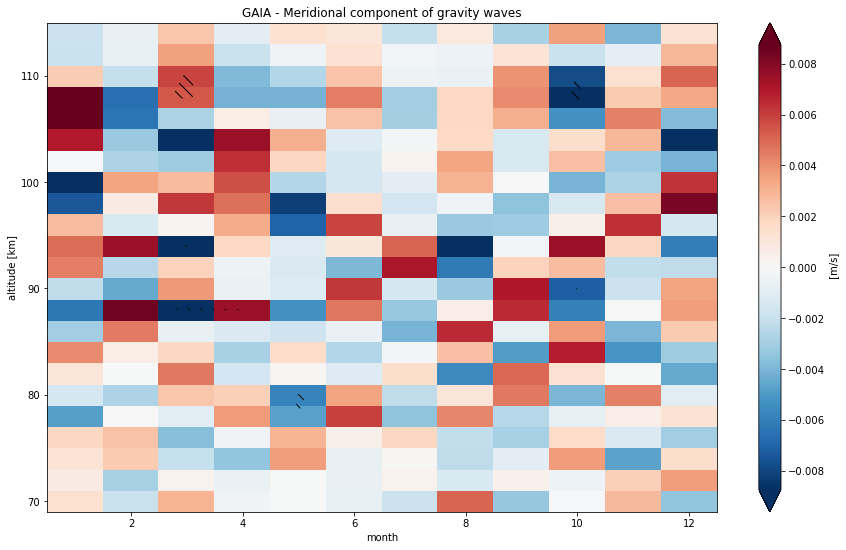

In [38]:
u_gw_statistics = time_reg_masked(u_gw_gaia_monthly_ano.groupby('time.month'))
u_gw_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


#u
temp = u_gw_statistics.sel(parameter='slope', alt = slice(70,115)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='month',figsize = [15,9], robust = True)
ax = p.axes
plot_kwargs2 = dict(x ='month',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = u_gw_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('GAIA - Meridional component of gravity waves')
ax.figure.savefig('results/cont_u_gw_gaia_'+station+'_mon.png')

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

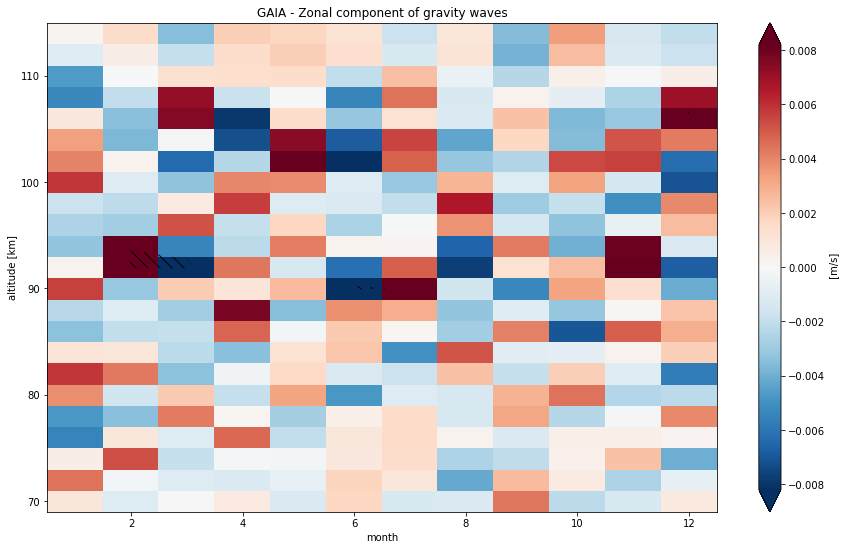

In [39]:
v_gw_statistics = time_reg_masked(v_gw_gaia_monthly_ano.groupby('time.month'))
v_gw_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


#u
temp = v_gw_statistics.sel(parameter='slope', alt = slice(70,115)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='month',figsize = [15,9], robust = True)
ax = p.axes
plot_kwargs2 = dict(x ='month',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = v_gw_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('GAIA - Zonal component of gravity waves')
ax.figure.savefig('results/cont_v_gw_gaia_'+station+'_mon.png')

## Plotting Radar + Gaia Measurements

### u

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


P Values: 
Radar   0.232
Gaia    0.002
results/CMA_10_76_u.png
Done with z: 76


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


P Values: 
Radar   0.222
Gaia    0.003
results/CMA_10_80_u.png


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Done with z: 80


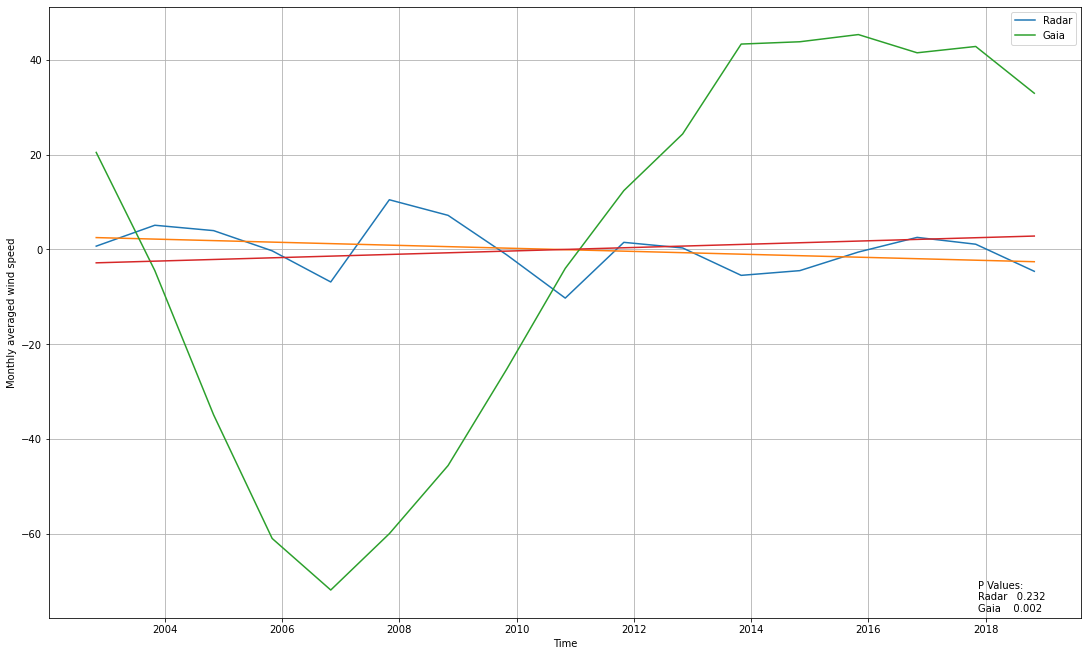

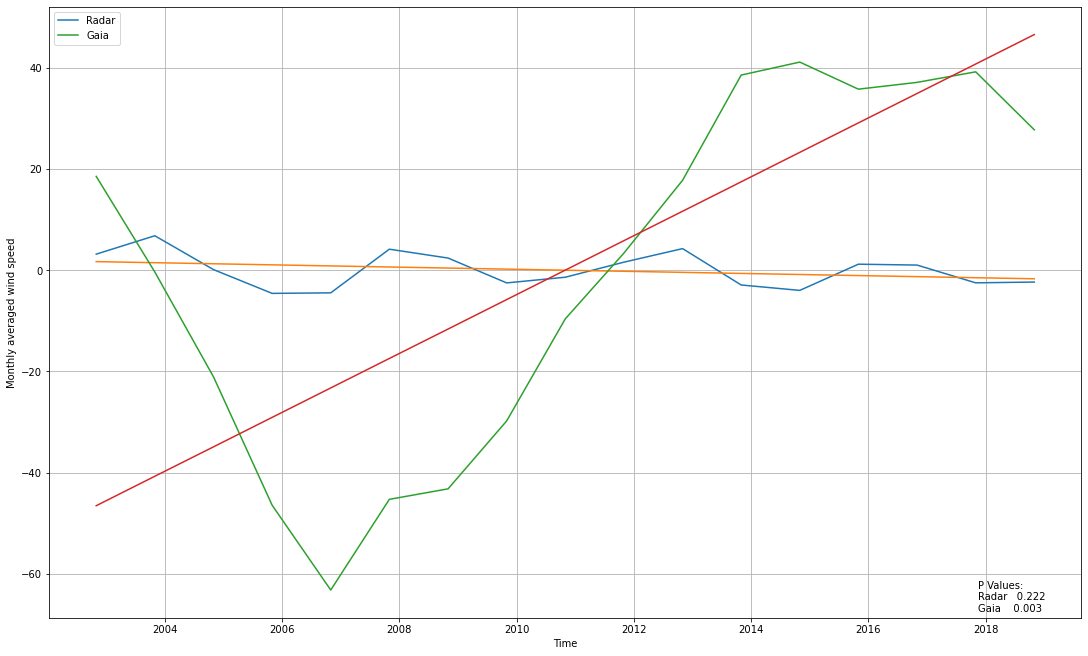

In [40]:

s = 10
e = 10
z = 106
for z in [76,80]:
    u_radar_examon = u_radar_monthly_ano.sel(time=is_mon(u_radar_monthly_ano['time.month'],s,e))
    u_gaia_examon = u_gaia_monthly_ano.sel(time=is_mon(u_gaia_monthly_ano['time.month'],s,e))

    x = np.arange(u_gaia_examon.time.shape[0])

    u_statistics_gaia = time_reg(u_gaia_examon)
    u_statistics_gaia['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
    reg_gaia = [m_gaia*i+n_gaia for i in x]

    x = np.arange(u_radar_examon.time.shape[0])
    u_statistics = time_reg(u_radar_examon)
    u_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']

    m = (u_statistics.sel(parameter='slope',alt=[z]))
    n = (u_statistics.sel(parameter='intercept',alt=[z]))
    m_gaia = (u_statistics_gaia.sel(parameter='slope',alt=[z]))
    n_gaia = (u_statistics_gaia.sel(parameter='intercept',alt=[z]))

    reg = [m*i+n for i in x]
    

    plotstring = '\n'.join((
        r'P Values: ',
        r'Radar   '+ str(round(*u_statistics.sel(parameter='p_value',alt=[z]).values,3 )),
        r'Gaia    '+ str(round(*u_statistics_gaia.sel(parameter = 'p_value',alt=[z]).values,3 ))))
    print(plotstring)

    savestring = 'results/'+station+'_'+str(s)+'_'+str(z)+'_u.png'
    print(savestring)
    fig = plt.figure(constrained_layout=True,figsize = [15,9])

    windsel_gaia = u_gaia_examon.sel(alt = [z], method = 'nearest')
    windsel_radar = u_radar_examon.sel(alt = [z], method = 'nearest')

    ax1 = fig.add_subplot(111)
    ax1.plot(u_radar_examon.time,windsel_radar, label = 'Radar')
    ax1.plot(u_radar_examon.time,reg)
    ax1.plot(u_gaia_examon.time,windsel_gaia, label = 'Gaia')
    ax1.plot(u_gaia_examon.time,reg_gaia)

    ax1.grid()
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Monthly averaged wind speed')
    ax1.legend()
    ax1.text(.9,0.01,plotstring, transform=ax1.transAxes)
    plt.savefig(savestring)
    print('Done with z: '+str(z))

### v  

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


P Values: 
Radar   0.348
Gaia    0.029


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Done with z: 84


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


P Values: 
Radar   0.524
Gaia    0.385


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Done with z: 102


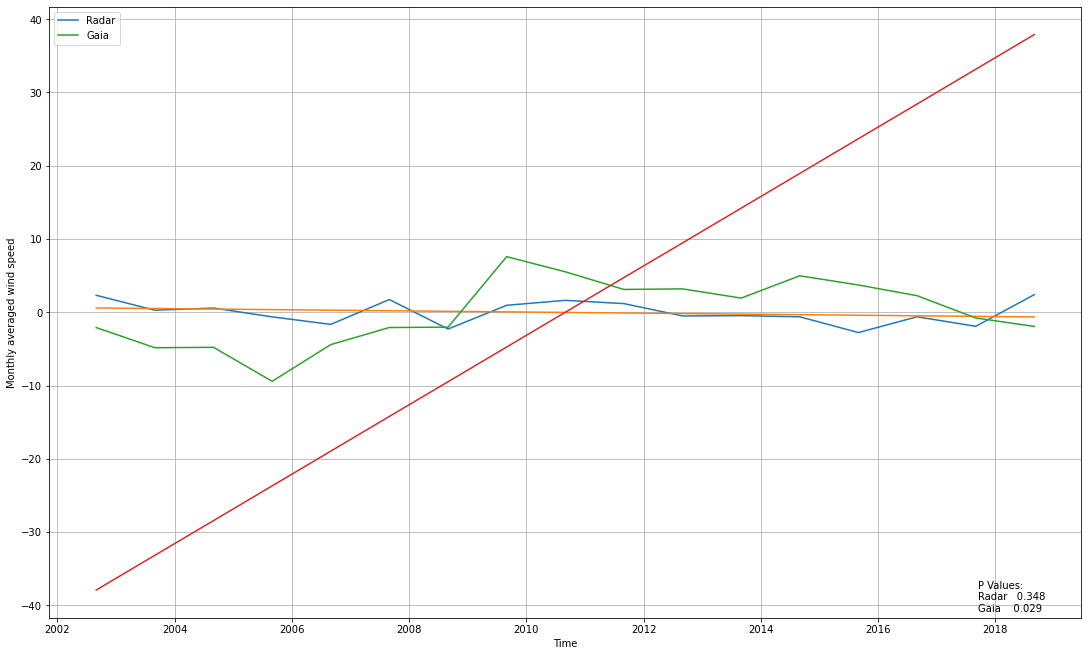

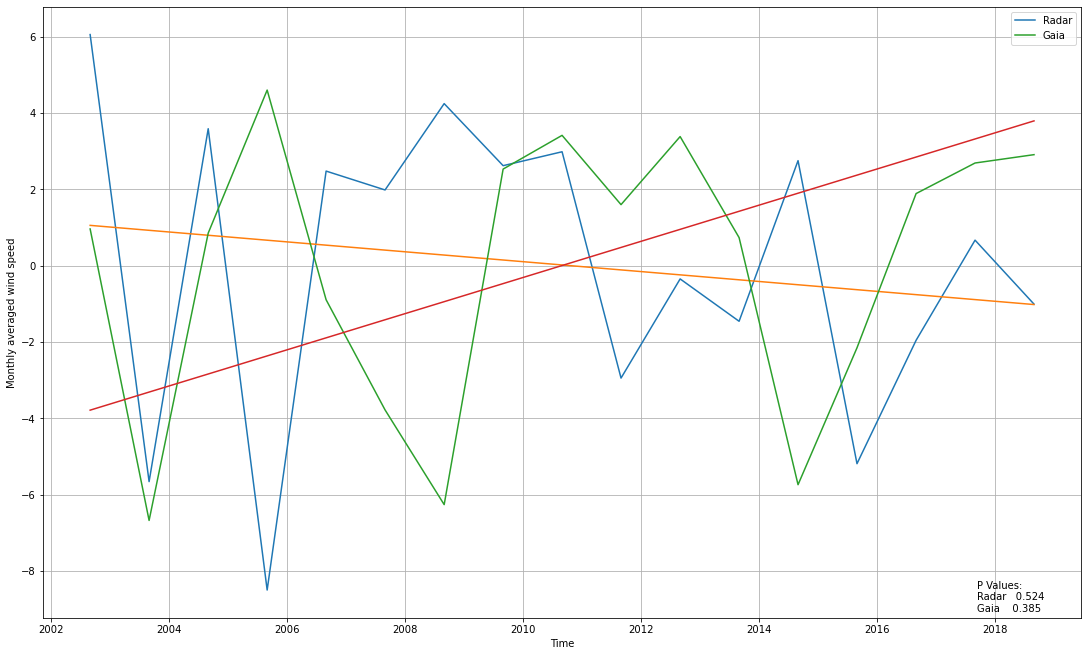

In [41]:

s = 8
e = 8
z = 102
for z in [84,102]:
    v_radar_examon = v_radar_monthly_ano.sel(time=is_mon(v_radar_monthly_ano['time.month'],s,e))
    v_gaia_examon = v_gaia_monthly_ano.sel(time=is_mon(v_gaia_monthly_ano['time.month'],s,e))

    x = np.arange(v_gaia_examon.time.shape[0])
    v_statistics_gaia = time_reg(v_gaia_examon)
    v_statistics_gaia['parameter'] = ['slope', 'intercept', 'r_valve','p_value', 'std_err']
    reg_gaia = [m_gaia*i+n_gaia for i in x]

    x = np.arange(v_radar_examon.time.shape[0])
    v_statistics = time_reg(v_radar_examon)
    v_statistics['parameter'] = ['slope', 'intercept', 'r_valve','p_value', 'std_err']

    m = (v_statistics.sel(parameter='slope',alt=[z]))
    n = (v_statistics.sel(parameter='intercept',alt=[z]))
    m_gaia = (v_statistics_gaia.sel(parameter='slope',alt=[z]))
    n_gaia = (v_statistics_gaia.sel(parameter='intercept',alt=[z]))

    reg = [m*i+n for i in x]


    plotstring = '\n'.join((
        r'P Values: ',
        r'Radar   '+ str(round(*v_statistics.sel(parameter='p_value',alt=[z]).values,3 )),
        r'Gaia    '+ str(round(*v_statistics_gaia.sel(parameter = 'p_value',alt=[z]).values,3 ))))
    print(plotstring)
    savestring = 'results/'+station+'_'+str(s)+'_'+str(z)+'_v.png'


    fig = plt.figure(constrained_layout=True,figsize = [15,9])

    windsel_gaia = v_gaia_examon.sel(alt = [z], method = 'nearest')
    windsel_radar = v_radar_examon.sel(alt = [z], method = 'nearest')

    ax1 = fig.add_subplot(111)
    ax1.plot(v_radar_examon.time,windsel_radar, label = 'Radar')
    ax1.plot(v_radar_examon.time,reg)
    ax1.plot(v_gaia_examon.time,windsel_gaia, label = 'Gaia')
    ax1.plot(v_gaia_examon.time,reg_gaia)

    ax1.grid()
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Monthly averaged wind speed')
    ax1.legend()
    ax1.text(.9,0.01,plotstring, transform=ax1.transAxes)
    plt.savefig(savestring)
    print('Done with z: '+str(z))

In [42]:
print('Done')

Done
